In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [ ]:
### create substitution cipher

# one will act as the key, other as the value
letter1 = list(string.ascii_lowercase)
letter2 = list(string.ascii_lowercase)

true_mappings = {}

# shuffle second set of letters
random.shuffle(letter2)

# populate map
true_mapping = dict(zip(letter1, letter2))
print(true_mapping)

{'a': 'z', 'b': 'p', 'c': 'g', 'd': 'd', 'e': 'r', 'f': 'l', 'g': 't', 'h': 'y', 'i': 'f', 'j': 'e', 'k': 'n', 'l': 'c', 'm': 'w', 'n': 'k', 'o': 'q', 'p': 'x', 'q': 'j', 'r': 'u', 's': 'o', 't': 'i', 'u': 'v', 'v': 's', 'w': 'h', 'x': 'b', 'y': 'a', 'z': 'm'}


In [ ]:
### the language model

# initialize Markov matrix
M = np.ones((26, 26))

# initial state distribution
pi = np.zeros(26)

# a function to update the Markov matrix
def update_transition(ch1, ch2):
    i = ord(ch1) - 97
    j = ord(ch2) - 97
    M[i,j] += 1
    # print("Markov Value =", M)
    
# a function to update the initial state distribution
def update_pi(ch1):
    i = ord(ch1) - 97
    pi[i] += 1
    # print("pi =", pi)
    
# get the log-probability of a word / token
def get_word_prob(word):
  # print("word:", word)
    i = ord(word[0]) - 97
    logp = np.log(pi[i])

    for ch in word[1:]:
      j = ord(ch) - 97
      logp += np.log(M[i, j]) # update prob
      i = j # update j
    return logp

# get the probability of a sequence of words
def get_sequence_prob(words):
  # if input is a string, split into an array of tokens
  if type(words) == str:
    words = words.split()
  logp = 0
    
  for word in words:
        logp += get_word_prob(word)
  return logp

In [ ]:
### create a markov model based on an English dataset
# is an edit of https://www.gutenberg.org/ebooks/2701
# (I removed the front and back matter)

# download the file
if not os.path.exists('moby_dick.txt'):
    print("Downloading moby dick...")
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
    with open('moby_dick.txt', 'w') as f:
        f.write(r.content.decode())
    
# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

# load in words
for line in open('moby_dick.txt'):
    line = line.rstrip()

  # there are blank lines in the file
    if line:
        line = regex.sub(' ', line) # replace all non-alpha characters with space

    # split the tokens in the line and lowercase
        tokens = line.lower().split()

    for token in tokens:
      # update the model

      # first letter position 0
        ch0 = token[0]
        update_pi(ch0)

      # other letters since position 1
        for ch1 in token[1:]:
            update_transition(ch0, ch1)
            ch0 = ch1
            
# # normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)


In [ ]:
### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

In [ ]:
# a function to encode a message
def encode_message(msg):
  msg = msg.lower()
  msg = regex.sub(' ', msg)

  coded_msg = [] #list
  for ch in msg:
    coded_ch = ch # could just be a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)
  return ''.join(coded_msg)

encoded_msg = encode_message(original_message)

def decode_message(msg, word_map):
  decoded_msg = []

  for ch in msg:
    decoded_ch = ch # could just be a space
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)
  
  return ''.join(decoded_msg)

In [ ]:
### run an evolutionary algorithm to decode the message

# this is our initialization point

dna_pool = []
for _ in range(20):
  dna = list(string.ascii_lowercase) # 20 sets of a-z
  random.shuffle(dna)
  dna_pool.append(dna)

In [ ]:
def evolve_offspring(dna_pool, n_children):
  # make n_children per offspring
  offspring = []
  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)
      #เปลี่ยนตัวอักษรที่ decode เป็น encode เช่น กำหนด a = c then now c = a

  return offspring + dna_pool

In [ ]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
  if i > 0:
    # get offspring from the current dna pool
    dna_pool = evolve_offspring(dna_pool, 3)

  # calculate score for each dna
  dna2score = {}
  for dna in dna_pool:
    # populate map
    current_map = {}
    for k, v in zip(letter1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_msg, current_map)
    score = get_sequence_prob(decoded_message)

    # store it
    # needs to be a string to be a dict key
    dna2score[''.join(dna)] = score

    # record the best so far
    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # keep the best 5 dna
  # also turn them back into list of single chars
  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)


iter: 0 score: -2111.6702485289284 best so far: -1900.2247942581919
iter: 200 score: -1143.7459848214207 best so far: -1082.5047271810774
iter: 400 score: -1022.5365861158938 best so far: -938.1342635242178
iter: 600 score: -1002.3233707837356 best so far: -929.9156356016822
iter: 800 score: -1036.0540772075328 best so far: -929.9156356016822


In [ ]:
# use best score
decoded_message = decode_message(encoded_msg, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))


# which letters are wrong?
for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.9156356016822
LL of true message: -933.4784822058451
true: j, pred: q
true: k, pred: z
true: q, pred: j
true: z, pred: k


In [ ]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

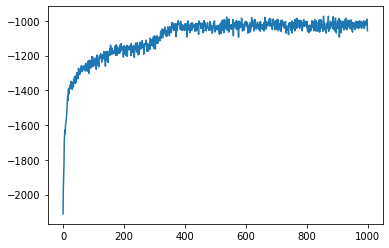

In [ ]:
plt.plot(scores)
plt.show()